### Compare the following off-policy evaulations on some environments.
### 1. Step-wise IS
### 2. Step-wise WIS
### 3. Regression estimator (REG)
### 4. Doubly robust (DR) estimator
### 5. DR with a state-action independent \hat{Q}

In [52]:
import gym
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Use off-policy Q-learning to form $\pi_{train}$

In [53]:
class TabularQAgent(object):
    """
    Agent implementing tabular Q-learning.
    """

    def __init__(self, observation_space, action_space, discretize=True, acceleration=4, **userconfig):
            
        self.observation_space = observation_space
        self.action_space = action_space
        self.action_n = action_space.n
        self.config = {
            "init_mean" : 0,      # Initialize Q values with this mean
            "init_std" : 0,       # Initialize Q values with this standard deviation
            "learning_rate" : 0.01,
            "eps": 1,          # NOTE: Epsilon set to 1 for making this Q-learning completely offline
            "gamma": 0.99,
            "horizon": 100,       # horizon length
            "n_episodes": 2000}     # Number of episodes
        self.config.update(userconfig)
        self.q = defaultdict(lambda: self.config["init_std"] * np.random.randn(self.action_n) \
                             + self.config["init_mean"])
        self.discretize = discretize
        self.acceleration=acceleration # Accelerate by taking the same action many times        

    def act(self, observation):
        # epsilon=1 greedy.
        action = self.action_space.sample()
        return action

    def learn(self, env):
        config = self.config
        lr = self.config["learning_rate"]
        num_episodes = config["n_episodes"]
        gamma = config["gamma"]
        horizon = config["horizon"]
        
        q = self.q
        final_rewards = np.zeros(num_episodes) # Array for storing final rewards
        
        for episode in range(num_episodes):
            obs = env.reset()
            done = 0
            H = 0

            if (episode % 1000) == 0:
                print "Running episode %d/%d." % (episode,num_episodes)
            
            while not done and H < horizon:
                if self.discretize:
                    # Discretizing the current state
                    obs_discrete = np.copy(obs)
                    obs_discrete *= [2**6, 2**8]
                    obs_discrete = tuple(np.round(obs_discrete))
                else:
                    obs_discrete = obs
                
                action = self.act(obs_discrete)
                
                for _ in range(self.acceleration):
                    next_obs, reward, done, _ = env.step(action)

                if self.discretize:
                    # Discretizing the next state
                    next_obs_discrete = np.copy(next_obs)
                    next_obs_discrete *= [2**6, 2**8]
                    next_obs_discrete = tuple(np.round(next_obs_discrete))
                else:
                    next_obs_discrete = next_obs
                
                if done:
                    best_next_obs = 0
                else:
                    best_next_obs = np.max(q[next_obs_discrete])
                
                q[obs_discrete][action] -= lr*(q[obs_discrete][action] - reward - gamma*best_next_obs)
                
                obs = next_obs

                final_rewards[episode] += reward
                    
                H += 1
                    
        return final_rewards

In [54]:
class ground_truth(object):
    def __init__(self,env,agent,D_eval = 5000,gamma=0.99,H=100,alpha=1,discretize=True,acceleration=4):
        self.env = env
        self.agent = agent
        self.D_eval = D_eval
        self.gamma = gamma
        self.Q = defaultdict(lambda:[0,0]) # Q-function values
        self.H = H
        self.acceleration=acceleration # Accelerate by taking the same action many times        
        self.N = self.env.action_space.n
        self.alpha=alpha
        self.eps = 0.0 # a small number (used either when computing 0/0 or to create float when dividing integers)
        self.discretize = discretize

        # Optimal policy pi_train
        self.pi_train = defaultdict(lambda: np.ones(self.N)*1/(self.N + self.eps))
        for observation in self.agent.q.keys():
            self.pi_train[observation] = np.zeros(self.N)
            action = np.argmax(agent.q[observation])
            self.pi_train[observation][action] = 1
        
        # Behavior policy
        self.pi_0 = defaultdict(lambda: np.ones(self.N)*1/(self.N + self.eps))

    # Target policy
    def pi_1(self,observation):
        return (1-self.alpha)*self.pi_train[observation] + self.alpha*self.pi_0[observation]
    
    def rollout(self):
        obs = self.env.reset()
        done = 0
        t = 0
        
        observations = []
        actions = []
        rewards = []
        
        while not done and t < self.H:
            if self.discretize:
                # Discretizing the state
                obs_discrete = np.copy(obs)
                obs_discrete *= [2**6, 2**8]
                obs_discrete = tuple(np.round(obs_discrete))
            else:
                obs_discrete = obs
                
            action = np.argmax(np.random.multinomial(1, self.pi_1(obs_discrete).reshape(self.N,)))
 
            for _ in range(self.acceleration):
                next_obs, reward, done, _ = self.env.step(action)

            observations.append(obs_discrete)
            actions.append(action)
            rewards.append(reward)
  
            obs = next_obs
            t += 1
        
        # Save true Q-function values in a dictionary
        gammas = np.zeros((t, t))
        gammas[:,0] = np.vander([self.gamma],t,increasing=True)
        for i in range(1,t):
            gammas[:,i] = gammas[:,i-1]/self.gamma
            gammas[i-1,i] = 0
        
        returns = np.array(rewards).dot(gammas)
        
        sa_keys = zip(observations,actions) # state-action key
        for i in xrange(t):
            self.Q[sa_keys[i]][0] += returns[i] # values
            self.Q[sa_keys[i]][1] += 1 # counts
        
        return rewards

    def collect_paths(self):
        num_paths = self.D_eval

        Rs = np.zeros((num_paths, self.H)) # Rewards as an array

        for path in xrange(num_paths):
            r = self.rollout()
            Rs[path,xrange(len(r))] = r
        
        return Rs

    def values(self):
                        
        Rs = self.collect_paths()
        
        # Create Vandermonde matrix of gamma values
        gammas = np.vander([self.gamma],self.H,increasing=True)
        
        # Ground Truth
        ground_truths = np.sum(gammas*Rs,axis=1)
        return ground_truths

In [75]:
class estimator(object):
    def __init__(self,env,agent,D_eval = 5000,D_test=4900,gamma=0.99,H=100,alpha=0,discretize=True,
                 acceleration=4,Q=None,use_oracle=False,std=None):
        self.env = env
        self.agent = agent
        self.D_eval = D_eval
        self.D_test = D_test
        self.D_reg = self.D_eval - self.D_test
        self.alpha = alpha
        self.gamma = gamma
        self.H = H
        self.acceleration=acceleration # Accelerate by taking the same action many times
        self.N = self.env.action_space.n
        self.eps = 0.0 # a small number (used either when computing 0/0 or to create float when dividing integers)
        self.discretize = discretize
        self.Q = Q
        self.use_oracle = use_oracle
        self.std = std # standard deviation of the noise to be added to the estimates of Q
        
        # Optimal policy pi_train
        self.pi_train = defaultdict(lambda: np.ones(self.N)*1/(self.N + self.eps))
        for observation in self.agent.q.keys():
            self.pi_train[observation] = np.zeros(self.N)
            action = np.argmax(agent.q[observation])
            self.pi_train[observation][action] = 1
        
        # Behavior policy
        self.pi_0 = defaultdict(lambda: np.ones(self.N)*1/(self.N + self.eps))

    # Target policy
    def pi_1(self,observation):
        return (1-self.alpha)*self.pi_train[observation] + self.alpha*self.pi_0[observation]
    
    def rollout(self):
        obs = self.env.reset()
        done = 0
        t = 0
        IR = 1 # importance ratio
        
        observations = []
        actions = []
        rewards = []
        IRs = []
        
        while not done and t < self.H:
            if self.discretize:
                # Discretizing the state
                obs_discrete = np.copy(obs)
                obs_discrete *= [2**6, 2**8]
                obs_discrete = tuple(np.round(obs_discrete))
            else:
                obs_discrete = obs
                
            action = np.argmax(np.random.multinomial(1, self.pi_0[obs_discrete].reshape(self.N,)))
                
            for _ in range(self.acceleration):
                next_obs, reward, done, _ = self.env.step(action)
                
            IR *= self.pi_1(obs_discrete)[action]/(self.pi_0[obs_discrete][action]+self.eps)
            
            observations.append(obs_discrete)
            actions.append(action)
            rewards.append(reward)
            IRs.append(IR)
                
            obs = next_obs
            t += 1
        
        next_observations = observations[1:]
        if self.discretize:
            # Discretizing the last state
            next_obs_discrete = np.copy(next_obs)
            next_obs_discrete *= [2**6, 2**8]
            next_obs_discrete = tuple(np.round(next_obs_discrete))
        else:
            next_obs_discrete = next_obs
            
        next_observations.append(next_obs_discrete)            
        
        metrics = (observations, actions, next_observations, rewards, IRs)

        return metrics
    
    def collect_paths(self):
        num_paths = self.D_eval
        H = self.H
        
        obs = []
        actions = []
        rewards = []
        next_obs = []
        horizons = []
        
        Rs = np.zeros((num_paths, H)) # Rewards as an array
        IRs = np.zeros((num_paths, H)) # IRs as an array
        
        for path in xrange(num_paths):
            o, a, no, r, IR = self.rollout()
            
            obs += o
            actions += a
            rewards += r
            next_obs += no
            h = len(r)
            horizons.append(h)
            
            Rs[path,xrange(h)] = r
            IRs[path,xrange(h)] = IR
        
        return obs, actions, rewards, next_obs, Rs, IRs, horizons

    def values(self):
                        
        obs, actions, rewards, next_obs, Rs, IRs, horizons = self.collect_paths()
               
        # Create Vandermonde matrix of gamma values
        gammas = np.vander([self.gamma],self.H,increasing=True)
        
        # IS
        IS_estimates = np.sum(gammas*IRs[self.D_reg:]*Rs[self.D_reg:], axis=1)
        
        # WIS
        w = np.mean(IRs[self.D_reg:],axis=0)
        WIS_estimates = np.sum(gammas*IRs[self.D_reg:]*Rs[self.D_reg:]/(w+self.eps),axis=1)

        # REG - WORKS only on the D_REG set
        reg_data_size = np.sum(horizons[:self.D_reg])
        
        obs_reg = obs[:reg_data_size]
        actions_reg = actions[:reg_data_size]
        rewards_reg = rewards[:reg_data_size]
        next_obs_reg = next_obs[:reg_data_size]
        
        # MDP dictionary: Given s, a, it stores next_s, state visit counts and rewards.
        # This can be used to compute p(s'|s,a)
        mdp = defaultdict(lambda: [defaultdict(lambda: 0), 0, 0])
        
        # Create the mdp dictionary
        sa_keys = zip(obs_reg,actions_reg) # state-action key
        for idx in xrange(len(actions_reg)):
            mdp[sa_keys[idx]][0][next_obs_reg[idx]] += 1
            mdp[sa_keys[idx]][1] += 1 # next_obs visit counts
            mdp[sa_keys[idx]][2] += rewards_reg[idx] # Total rewards
        
        V = defaultdict(lambda: 0)
        Q = {}
        REG_estimates = []
        
        begin = 0
        default_reward = -1                
        for h in horizons[:self.D_reg]:
            default_val = 0
            
            end = begin + h
            S = obs_reg[begin:end][::-1]
            A = actions_reg[begin:end][::-1]
            
            for idx in xrange(0,h):
                s = S[idx]
                a = A[idx]
                s_next = mdp.get((s,a))[0].keys() # Next states possible from s
                prob = np.array(mdp.get((s,a))[0].values())/(mdp.get((s,a))[1] + self.eps) # Probabilities
                Reward = mdp.get((s,a))[2]/(mdp.get((s,a))[1] + self.eps) # Avg. Reward
                Values = [V.get(state,default_val) for state in s_next] # Next state values                
                Q[(s,a)] = prob.dot(Reward + self.gamma*np.array(Values))
               
                default_val = default_reward + self.gamma*default_val # default value update for the MDP
                
                prob = self.pi_1(s)
                Qs = np.array([Q.get((s,action), default_val) for action in xrange(self.N)])
                V[s] = prob.dot(Qs)

            begin = end
            REG_estimates.append(V[s])

        # DR
        DR_estimates = []
        
        obs_test = obs[reg_data_size:]
        actions_test = actions[reg_data_size:]
        rewards_test = rewards[reg_data_size:]

        begin = 0
                
#        import pandas as pd
#        df = pd.DataFrame(columns=["S","A","R","Q_hat","V_hat","IR","pi_1","pi_0","V_DR"])        
        
        for h in horizons[self.D_reg:]:
            
            V_DR = 0
            
            default_val = 0
            end = begin + h
            S = obs_test[begin:end][::-1]
            A = actions_test[begin:end][::-1]
            R = rewards_test[begin:end][::-1]
            
            for idx in xrange(0,h):
                s = S[idx]
                a = A[idx]
                
                if self.use_oracle: # used when Q is obtained directly from traces (oracle)
                # Create new Q dictionary averaging across trajectories
                    Q = {}
                    for key in self.Q.keys():
                        # Adding noise to the Q values
                        Q[key] = self.Q[key][0]/(self.Q[key][1]+self.eps) + np.random.normal(scale=self.std)
                
                Q_hat = Q.get((s,a), default_val)
                prob = self.pi_1(s)
                Qs = np.array([Q.get((s,action), default_val) for action in xrange(self.N)])
                
                #V_hat = V.get(s,default_val)
                V_hat = prob.dot(Qs)
                
                IR = self.pi_1(s)[a]/(self.pi_0[s][a]+self.eps)
                #IR = np.min((1.0,IR))
                
                # Write abnormal values into a data frame for further study
                #df.loc[idx] = [s,a,R[idx],Q_hat,V_hat,IR,self.pi_1(s)[a],self.pi_0[s][a],V_DR]
                
                V_DR = V_hat + IR*(R[idx] + self.gamma * V_DR - Q_hat)
                
                default_val = default_reward + self.gamma*default_val
            
            begin = end
            DR_estimates.append(V_DR)

        return IS_estimates, WIS_estimates, REG_estimates, DR_estimates

## MOUNTAIN CAR

[2016-08-29 00:06:32,879] Making new env: MountainCar-v0


Running episode 0/200000.
Running episode 1000/200000.
Running episode 2000/200000.
Running episode 3000/200000.
Running episode 4000/200000.
Running episode 5000/200000.
Running episode 6000/200000.
Running episode 7000/200000.
Running episode 8000/200000.
Running episode 9000/200000.
Running episode 10000/200000.
Running episode 11000/200000.
Running episode 12000/200000.
Running episode 13000/200000.
Running episode 14000/200000.
Running episode 15000/200000.
Running episode 16000/200000.
Running episode 17000/200000.
Running episode 18000/200000.
Running episode 19000/200000.
Running episode 20000/200000.
Running episode 21000/200000.
Running episode 22000/200000.
Running episode 23000/200000.
Running episode 24000/200000.
Running episode 25000/200000.
Running episode 26000/200000.
Running episode 27000/200000.
Running episode 28000/200000.
Running episode 29000/200000.
Running episode 30000/200000.
Running episode 31000/200000.
Running episode 32000/200000.
Running episode 33000/2

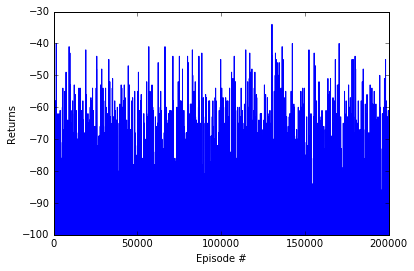

In [76]:
env = gym.make('MountainCar-v0')

# Use tabular Q-learning in order to obtain pi_train
D_train = 200000
agent = TabularQAgent(env.observation_space,env.action_space,n_episodes=D_train)
final_rewards = agent.learn(env)

plt.plot(final_rewards)
plt.ylabel('Returns')
plt.xlabel('Episode #')

### The total number of (s,a) tuples in the mountain car problem is (np.round(0.6*2**6) - np.round(-1.2*2**6) + 1) * (np.round(0.07*2**8) - np.round(-0.07*2**8) + 1) * 3 = 12876. However, inspite of a LOT of runs, we never witness all the state, action pairs in the rollouts.

In [ ]:
sim = ground_truth(env,agent,D_eval=100000,alpha=0.5)
results = sim.values()
print len(sim.Q)

### Plotting mean and variance of the estimates

0.01
0.25
0.5
0.75
1.0


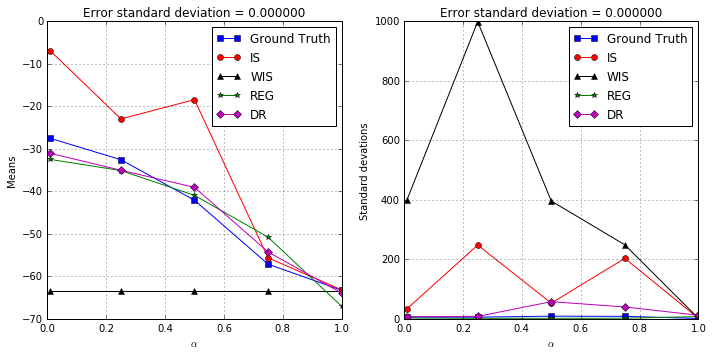

In [81]:
for std in [1e-8]:#[1e-8, 0.01, 0.05, 0.1, 0.5, 1]:

    mean_ground_truth = []
    mean_IS_estimates = []
    mean_WIS_estimates = []
    mean_REG_estimates = []
    mean_DR_estimates = []

    std_ground_truth = []
    std_IS_estimates = []
    std_WIS_estimates = []
    std_REG_estimates = []
    std_DR_estimates = []

    alphas = [0.01, 0.25, 0.5, 0.75, 1.0]
    for alpha in alphas:
        print alpha
        sim = ground_truth(env,agent,D_eval=50000,alpha=alpha)
        
        true_values = sim.values()
        mean_ground_truth.append(np.mean(true_values))
        std_ground_truth.append(np.std(true_values))
        oracle_Q = sim.Q

        sim = estimator(env,agent,D_test=500,D_eval=5000,alpha=alpha,Q=oracle_Q,use_oracle=False,std=std)
        estimates = sim.values()
        mean_IS_estimates.append(np.mean(estimates[0]))
        mean_WIS_estimates.append(np.mean(estimates[1]))
        mean_REG_estimates.append(np.mean(estimates[2]))
        mean_DR_estimates.append(np.mean(estimates[3]))   

        std_IS_estimates.append(np.std(estimates[0]))
        std_WIS_estimates.append(np.std(estimates[1]))
        std_REG_estimates.append(np.std(estimates[2]))
        std_DR_estimates.append(np.std(estimates[3]))

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title('Error standard deviation = %f' % std)    
    plt.plot(alphas, mean_ground_truth, 'bs-', label='Ground Truth')
    plt.plot(alphas, mean_IS_estimates, 'ro-', label='IS')
    plt.plot(alphas, mean_WIS_estimates, 'k^-', label='WIS')
    plt.plot(alphas, mean_REG_estimates, 'g*-', label='REG')
    plt.plot(alphas, mean_DR_estimates, 'mD-', label='DR')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Means')
    plt.legend(loc=0)
    plt.grid()

    plt.subplot(122)
    plt.title('Error standard deviation = %f' % std)    
    plt.plot(alphas, std_ground_truth, 'bs-', label='Ground Truth')
    plt.plot(alphas, std_IS_estimates, 'ro-', label='IS')
    plt.plot(alphas, std_WIS_estimates, 'k^-', label='WIS')
    plt.plot(alphas, std_REG_estimates, 'g*-', label='REG')
    plt.plot(alphas, std_DR_estimates, 'mD-', label='DR')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Standard devations')
    plt.legend(loc=0)
    plt.grid()

    plt.tight_layout()

### Ground truth of policy $\pi_1$ and its comparison with the other estimates for different $\alpha$ and $|D_{test}|$ values

In [79]:
alphas = [1e-5,0.25,0.5,0.75]
D_test_list = [10,100,1000,2000,3000,4000,4900,4990]
idx1 = 0
n_draws = 10

V = np.zeros(len(alphas))
V_hat_IS = np.zeros((len(alphas), len(D_test_list), n_draws))
V_hat_WIS = np.zeros((len(alphas), len(D_test_list), n_draws))
V_hat_REG = np.zeros((len(alphas), len(D_test_list), n_draws))
V_hat_DR = np.zeros((len(alphas), len(D_test_list), n_draws))

for alpha in alphas:
    print "alpha =", alpha
    # True value    
    sim = ground_truth(env,agent,alpha=alpha,D_eval=5000)
    V[idx1] = np.mean(sim.values())
    
    idx2 = 0
    for D_test in D_test_list:
        print "D_test = ", D_test
        sim = estimator(env,agent,D_test=D_test,alpha=alpha)

        for draw in xrange(n_draws):
            IS, WIS, REG, DR = sim.values()
            V_hat_IS[idx1, idx2, draw] = np.mean(IS)
            V_hat_WIS[idx1, idx2, draw] = np.mean(WIS)
            V_hat_REG[idx1, idx2, draw] = np.mean(REG)
            V_hat_DR[idx1, idx2, draw] = np.mean(DR)
            
        idx2 += 1
        
    idx1 += 1    

alpha = 1e-05
D_test =  10
D_test =  100
D_test =  1000
D_test =  2000
D_test =  3000
D_test =  4000
D_test =  4900
D_test =  4990
alpha = 0.25
D_test =  10
D_test =  100
D_test =  1000
D_test =  2000
D_test =  3000
D_test =  4000
D_test =  4900
D_test =  4990
alpha = 0.5
D_test =  10
D_test =  100
D_test =  1000
D_test =  2000
D_test =  3000
D_test =  4000
D_test =  4900
D_test =  4990
alpha = 0.75
D_test =  10
D_test =  100
D_test =  1000
D_test =  2000
D_test =  3000
D_test =  4000
D_test =  4900
D_test =  4990


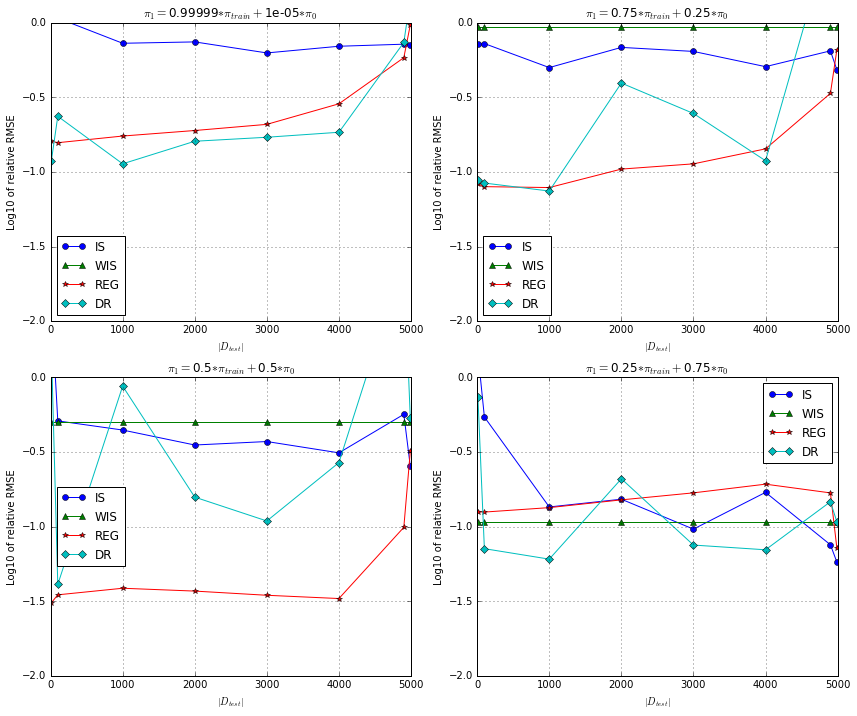

In [80]:
alphas = [1e-5,0.25,0.5,0.75]
D_test_list = [10,100,1000,2000,3000,4000,4900,4990]

plt.figure(figsize=(12,10))

RMSE_IS = np.log10(np.sqrt(np.mean((1-V_hat_IS/V.reshape(-1,1,1))**2,axis=2)))
RMSE_WIS = np.log10(np.sqrt(np.mean((1-V_hat_WIS/V.reshape(-1,1,1))**2,axis=2)))
RMSE_REG = np.log10(np.sqrt(np.mean((1-V_hat_REG/V.reshape(-1,1,1))**2,axis=2)))
RMSE_DR = np.log10(np.sqrt(np.mean((1-V_hat_DR/V.reshape(-1,1,1))**2,axis=2)))

idx = 0
for alpha in alphas:
    # Plotting
    plt.subplot(220+idx+1)
    string = '$\pi_1=$'+ str(1-alpha) + '$*\pi_{train} + $' + str(alpha) + '$*\pi_0$'
    plt.title(string)
    plt.ylabel('Log10 of relative RMSE')
    plt.xlabel('$|D_{test}|$')
    plt.plot(D_test_list,RMSE_IS[idx,:], 'o-', label='IS')
    plt.plot(D_test_list,RMSE_WIS[idx,:], '^-', label='WIS')
    plt.plot(D_test_list,RMSE_REG[idx,:], '*-', label='REG')
    plt.plot(D_test_list,RMSE_DR[idx,:], 'D-', label='DR')
    plt.legend(loc=0)
    plt.ylim([-2, 0])
    plt.grid()
    idx += 1

plt.tight_layout()

## Frozen Lake

### Study the effect of noisy $\hat{Q}$ on the DR estimates using the frozen lake environment.

In [65]:
#FLenv = gym.make('FrozenLake-v0')

# Create a non-slippery version of Frozen Lake
from gym.envs.registration import register, spec

MY_ENV_NAME='FrozenLakeNonSlippery-v0'
try:
    spec(MY_ENV_NAME)
except:
    register(
        id=MY_ENV_NAME,
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name': '4x4', 'is_slippery': False},
    )
FLenv = gym.make(MY_ENV_NAME)

[2016-08-27 23:29:31,910] Making new env: FrozenLakeNonSlippery-v0


Running episode 0/2000.
Running episode 1000/2000.


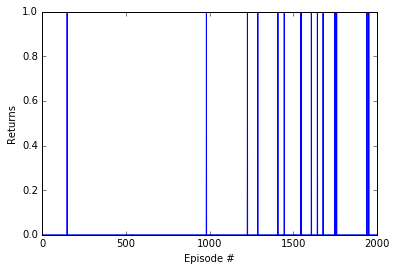

In [66]:
# Use tabular Q-learning in order to obtain pi_train
D_train = 2000
FLagent = TabularQAgent(FLenv.observation_space,FLenv.action_space,discretize=False,n_episodes=D_train,
                        acceleration=1)
final_rewards = FLagent.learn(FLenv)

plt.plot(final_rewards)
plt.ylabel('Returns')
plt.xlabel('Episode #')

In [67]:
sim = ground_truth(FLenv,FLagent,D_eval=10000,alpha=1,acceleration=1,discretize=False)
results = sim.values()
print len(sim.Q)

44


5000
10000
20000
50000


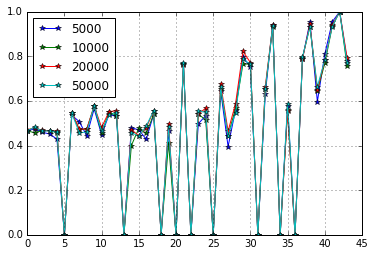

In [9]:
D_eval_list = [5000,10000,20000,50000]
alpha = np.random.rand()

for D_eval in D_eval_list:
    print D_eval
    sim = ground_truth(FLenv,FLagent,D_eval=D_eval,alpha=alpha,acceleration=1,discretize=False)
    sim.values()
    V = np.zeros(44)

    index = 0
    for state in [0,1,2,3,4,6,8,9,10,13,14]:
        for action in xrange(4):
            V[index] = sim.Q[(state,action)][0]/(sim.Q[(state,action)][1]+1e-25)
            index += 1
    plt.plot(V,'*-')
    
plt.legend(D_eval_list,loc=2)
plt.grid()

0.01


/home/sunil/.local/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide


0.25
0.5
0.75
1.0
0.01
0.25
0.5
0.75
1.0
0.01
0.25
0.5
0.75
1.0
0.01
0.25
0.5
0.75
1.0
0.01
0.25
0.5
0.75
1.0
0.01
0.25
0.5
0.75
1.0


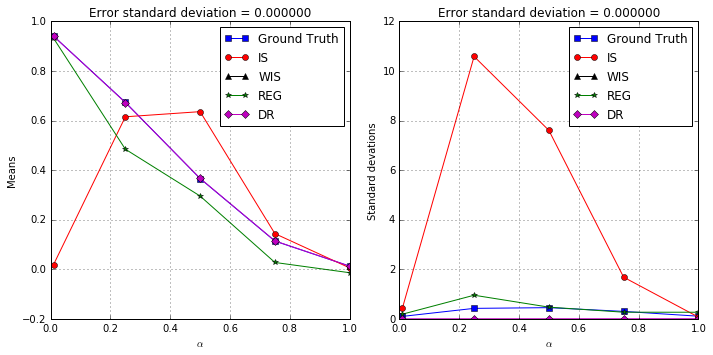

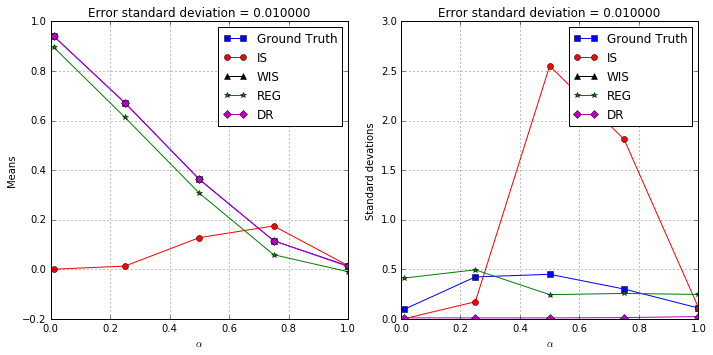

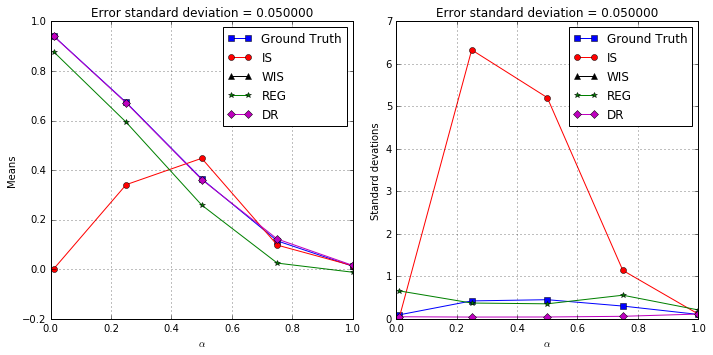

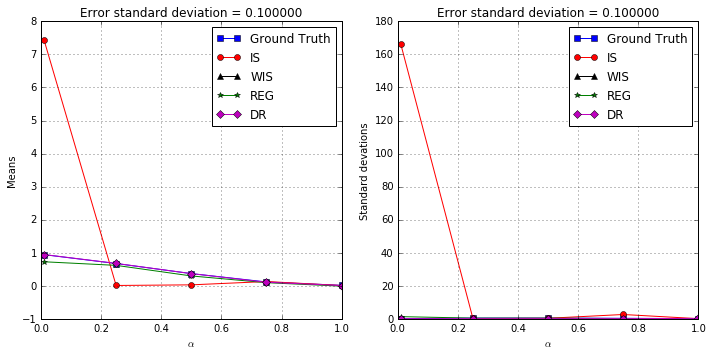

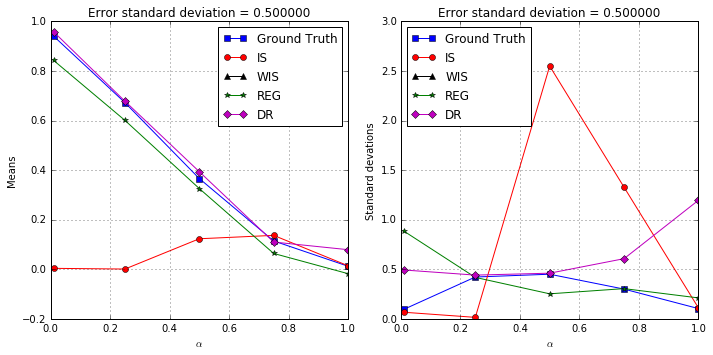

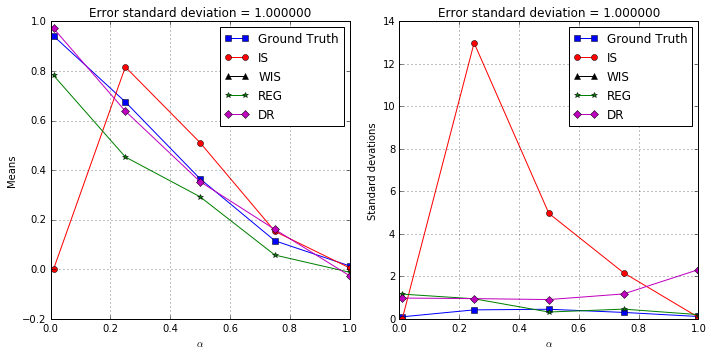

In [72]:
for std in [1e-8, 0.01, 0.05, 0.1, 0.5, 1]:

    mean_ground_truth = []
    mean_IS_estimates = []
    mean_WIS_estimates = []
    mean_REG_estimates = []
    mean_DR_estimates = []

    std_ground_truth = []
    std_IS_estimates = []
    std_WIS_estimates = []
    std_REG_estimates = []
    std_DR_estimates = []

    alphas = [0.01, 0.25, 0.5, 0.75, 1.0]
    for alpha in alphas:
        print alpha
        sim = ground_truth(FLenv,FLagent,D_eval=50000,alpha=alpha,acceleration=1,discretize=False)
        
        true_values = sim.values()
        mean_ground_truth.append(np.mean(true_values))
        std_ground_truth.append(np.std(true_values))
        oracle_Q = sim.Q

        sim = estimator(FLenv,FLagent,D_test=500,D_eval=5000,alpha=alpha,acceleration=1,discretize=False,Q=oracle_Q,
                        use_oracle=True,std=std)
        estimates = sim.values()
        mean_IS_estimates.append(np.mean(estimates[0]))
        mean_WIS_estimates.append(np.mean(estimates[1]))
        mean_REG_estimates.append(np.mean(estimates[2]))
        mean_DR_estimates.append(np.mean(estimates[3]))   

        std_IS_estimates.append(np.std(estimates[0]))
        std_WIS_estimates.append(np.std(estimates[1]))
        std_REG_estimates.append(np.std(estimates[2]))
        std_DR_estimates.append(np.std(estimates[3]))

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title('Error standard deviation = %f' % std)    
    plt.plot(alphas, mean_ground_truth, 'bs-', label='Ground Truth')
    plt.plot(alphas, mean_IS_estimates, 'ro-', label='IS')
    plt.plot(alphas, mean_WIS_estimates, 'k^-', label='WIS')
    plt.plot(alphas, mean_REG_estimates, 'g*-', label='REG')
    plt.plot(alphas, mean_DR_estimates, 'mD-', label='DR')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Means')
    plt.legend(loc=0)
    plt.grid()

    plt.subplot(122)
    plt.title('Error standard deviation = %f' % std)    
    plt.plot(alphas, std_ground_truth, 'bs-', label='Ground Truth')
    plt.plot(alphas, std_IS_estimates, 'ro-', label='IS')
    plt.plot(alphas, std_WIS_estimates, 'k^-', label='WIS')
    plt.plot(alphas, std_REG_estimates, 'g*-', label='REG')
    plt.plot(alphas, std_DR_estimates, 'mD-', label='DR')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Standard devations')
    plt.legend(loc=0)
    plt.grid()

    plt.tight_layout()